In [1]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time
import numpy as np

In [3]:
CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [27]:
colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']

In [144]:
sql = '''SELECT *
FROM (SELECT *, dep_time - LAG(dep_time) OVER w as headway
	FROM ttc.trip_stops
	WINDOW w AS (PARTITION BY stop_uid ORDER BY dep_time)) as headway
WHERE headway < '01:30:00'::interval'''

headway = pandasql.read_sql(sql, con)

In [145]:
headway = headway.dropna()
headway = headway.headway.apply(lambda x: x/pd.Timedelta('1 minute'))

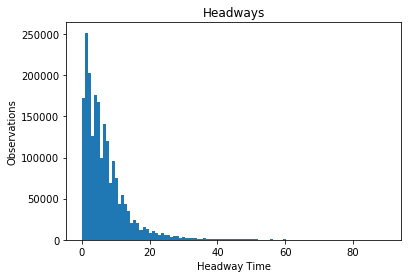

In [175]:
plt.hist(headway, bins = 100)
plt.title('Headways')
plt.xlabel('Headway Time')
plt.ylabel('Observations')
plt.show()

In [140]:
sql = '''WITH headway as (
SELECT *, dep_time - LAG(dep_time) OVER w as headway
FROM ttc.trip_stops
WHERE stop_uid IN (7, 8, 76, 77)
WINDOW w AS (PARTITION BY stop_uid ORDER BY dep_time)
order by dep_time)

SELECT stop_uid, stop_name || ', ' || direction || 'BOUND' as stop_name,
	CASE WHEN EXTRACT(ISODOW FROM dep_time) < 6 THEN 'Weekday' ELSE 'Weekend' END as day_type,
	'2017-01-01'::timestamp + (EXTRACT(hour FROM dep_time) || ' hour')::interval as hour_bin, 
	EXTRACT(epoch FROM percentile_cont(0.95) WITHIN GROUP (ORDER BY headway) - avg(headway)) AS potential_wait,
	avg(EXTRACT(epoch FROM headway)^2)/(2*avg(EXTRACT(epoch FROM headway))) as expected_wait
FROM headway 
	INNER JOIN ttc.stops stops USING(stop_uid)
	LEFT OUTER JOIN ref.holiday hol ON (hol.dt = dep_time::date)
WHERE headway BETWEEN '00:00:00'::interval AND '01:30:00'::interval
	AND hol.dt IS NULL
GROUP BY hour_bin, stop_uid, stop_name, direction, day_type'''

hway_metrics = pandasql.read_sql(sql, con)

In [141]:
stops = []
for stop in hway_metrics.stop_uid.unique():
    stops.append([hway_metrics[(hway_metrics.stop_uid == stop) & (hway_metrics.day_type == 'Weekday')],
                 hway_metrics[(hway_metrics.stop_uid == stop) & (hway_metrics.day_type == 'Weekend')]])

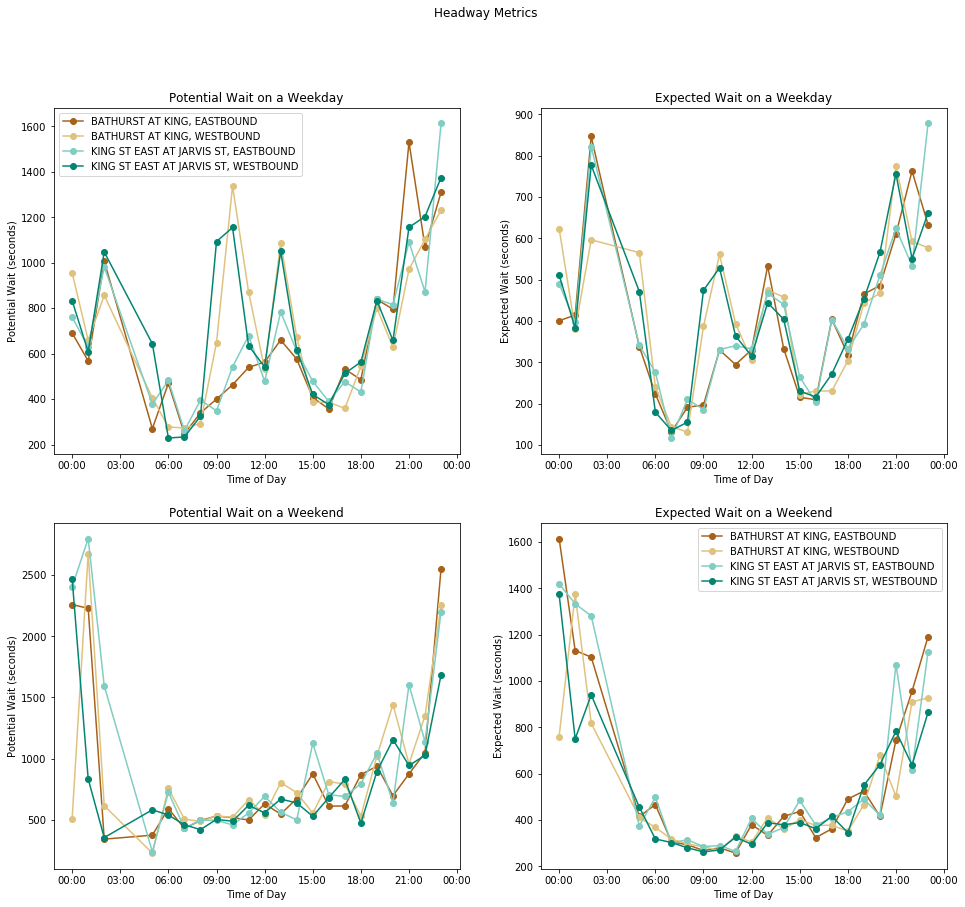

In [143]:
fig, ax = plt.subplots(2, 2, figsize = (16,14))
for i, stop in enumerate(stops):
    for j, day in enumerate(stop):
        ax[j, 0].plot_date(x = day.hour_bin,
                        y = day.potential_wait,
                        xdate = True,
                        fmt = '-o',
                        color = colors[i])
        ax[j, 1].plot_date(x = day.hour_bin,
                        y = day.expected_wait,
                        xdate = True,
                        fmt = '-o',
                        c = colors[i])
        
        ax[j, 0].xaxis.set_label_text('Time of Day')
        ax[j, 1].yaxis.set_label_text('Expected Wait (seconds)')
        ax[j, 1].xaxis.set_label_text('Time of Day')
        ax[j, 0].yaxis.set_label_text('Potential Wait (seconds)')
        
        ax[j, 0].set_title('Potential Wait on a ' + day.day_type.unique()[0])
        ax[j, 1].set_title('Expected Wait on a ' + day.day_type.unique()[0])
        
plt.suptitle('Headway Metrics')

for i in range(0,2):
    for j in range(0,2):
        ax[i,j].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 3))
        ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i,i].legend(hway_metrics.stop_name.unique())
        
plt.show()

Weekday graphs have the least headway early in the AM and PM peak periods. In the AM the eastbound stations are fairly low, though they remain on par with westbound (expected wait eastbound exceeds westbound shortly) during PM Peak. With some exceptions, Bathurst and Jarvis fit one another fairly nicely for a given direction. 
Over the weekend daytime headway is fairly constant with a sharp increase at night.

In [130]:
sql = '''WITH journeys as (
	SELECT trip_uid, min(stop_uid) as stop_uid,
		max(dep_time) - min(dep_time) as journey, 
		min(dep_time) as start, 
		max(dep_time) as end
	FROM (SELECT *
		FROM ttc.trip_stops
		WHERE stop_uid IN (7, 76) OR stop_uid IN (8, 77)) as 
	WHERE trip_uid NOT IN (27549, 23448)
	GROUP BY trip_uid
	ORDER BY journey)
SELECT stop_uid,
	direction ||'BOUND' as direction, 
	CASE WHEN EXTRACT(ISODOW FROM start) < 6 THEN 'Weekday' ELSE 'Weekend' END as day_type,
	'2017-01-01'::timestamp + (EXTRACT(hour FROM start) || ' hour')::interval as hour_bin,
	EXTRACT(epoch FROM percentile_cont(0.95) WITHIN GROUP (ORDER BY journey) - avg(journey)) AS buffer_time
FROM journeys
	INNER JOIN ttc.stops stops USING (stop_uid)
GROUP BY direction, stop_uid, stop_name, day_type, hour_bin'''

buffer_time = pandasql.read_sql(sql, con)

In [136]:
directions = []
for direction in buffer_time.direction.unique():
    directions.append([buffer_time[(buffer_time.direction == direction) & (buffer_time.day_type == 'Weekday')],
                 buffer_time[(buffer_time.direction == direction) & (buffer_time.day_type == 'Weekend')]])

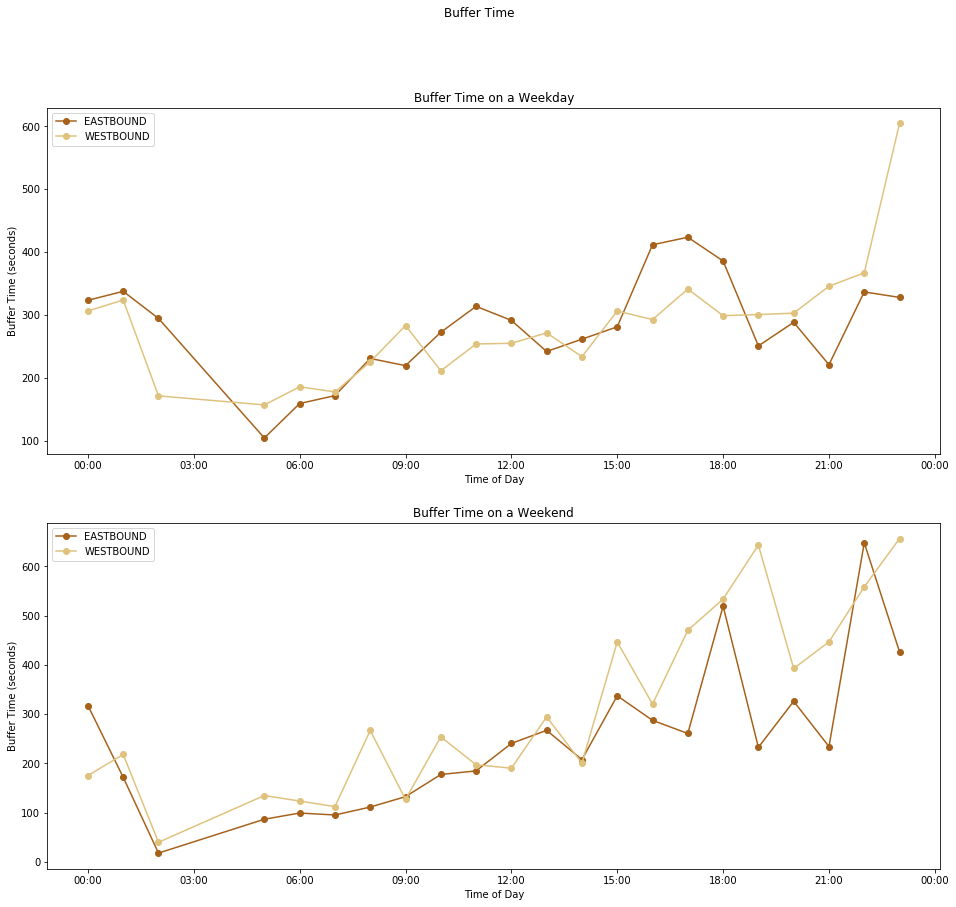

In [138]:
fig, ax = plt.subplots(2, 1, figsize = (16,14))
for i, direction in enumerate(directions):
    for j, day in enumerate(direction):
        ax[j].plot_date(x = day.hour_bin,
                        y = day.buffer_time,
                        xdate = True,
                        fmt = '-o',
                        color = colors[i])
        
        ax[j].xaxis.set_label_text('Time of Day')
        ax[j].yaxis.set_label_text('Buffer Time (seconds)')
        
        ax[j].set_title('Buffer Time on a ' + day.day_type.unique()[0])
        
plt.suptitle('Buffer Time')

for i in range(0,2):
    ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 3))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i].legend(buffer_time.direction.unique())
        
plt.show()

In [147]:
sql = '''WITH headway as (
SELECT *, dep_time - LAG(dep_time) OVER w as headway
FROM ttc.trip_stops
WHERE stop_uid IN (7, 8, 76, 77)
WINDOW w AS (PARTITION BY stop_uid ORDER BY dep_time)
order by dep_time)

SELECT stop_uid, stop_name || ', ' || direction || 'BOUND' as stop_name,
	CASE WHEN EXTRACT(ISODOW FROM dep_time) < 6 THEN 'Weekday' ELSE 'Weekend' END as day_type,
	'2017-01-01'::timestamp + (EXTRACT(hour FROM dep_time) || ' hour')::interval as hour_bin, 
	EXTRACT(epoch FROM percentile_cont(0.95) WITHIN GROUP (ORDER BY headway)) as pct_95,
	avg(EXTRACT(epoch FROM headway)^2)/(2*avg(EXTRACT(epoch FROM headway))) as expected_wait,
	EXTRACT(epoch FROM avg(headway/2)) as average_wait
FROM headway 
	INNER JOIN ttc.stops stops USING(stop_uid)
	LEFT OUTER JOIN ref.holiday hol ON (hol.dt = dep_time::date)
WHERE headway BETWEEN '00:00:00'::interval AND '01:30:00'::interval
	AND hol.dt IS NULL
GROUP BY hour_bin, stop_uid, stop_name, direction, day_type'''

headway_metrics = pandasql.read_sql(sql, con)

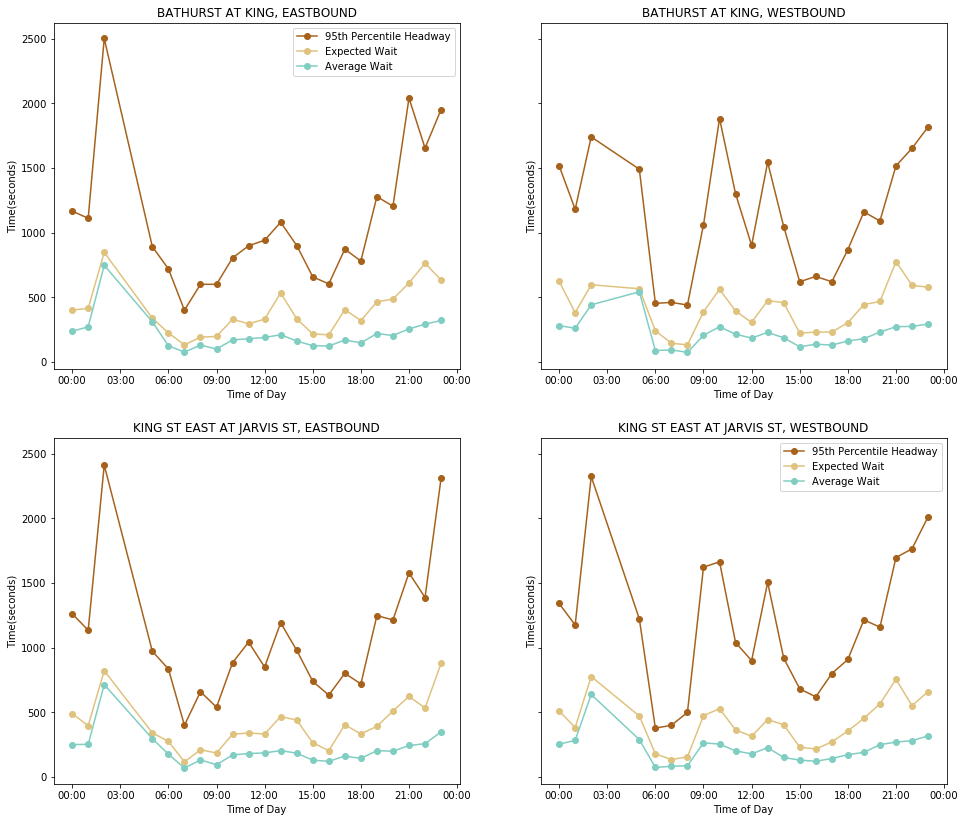

In [178]:
week_metrics = headway_metrics[headway_metrics.day_type == 'Weekday']
fig, axe = plt.subplots(2,2, figsize = (16,14), sharey = True)
for stop, ax in zip(week_metrics.stop_name.unique(), fig.axes):
    data = week_metrics[week_metrics.stop_name == stop]
    ax.plot_date(x = data.hour_bin,
                 y = data.pct_95,
                 xdate = True,
                 fmt = '-o',
                 color = colors[0])
    ax.plot_date(x = data.hour_bin,
                 y = data.expected_wait,
                 xdate = True,
                 fmt = '-o',
                 color = colors[1])
    ax.plot_date(x = data.hour_bin,
                 y = data.average_wait,
                 xdate = True,
                 fmt = '-o',
                 color = colors[2])
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax.xaxis.set_label_text('Time of Day')
    ax.yaxis.set_label_text('Time(seconds)')
    ax.set_title(stop)
axe[0,0].legend(['95th Percentile Headway', 'Expected Wait', 'Average Wait'])
axe[1,1].legend(['95th Percentile Headway', 'Expected Wait', 'Average Wait'])
plt.show()